### Operation based representation

A permutation is used to 

The paper by (Gen et al., 1994) use a operation based representation and also call it indirect. 

Survey of different representations classified in direct and indirect representations:
(Cheng et al., 1996)

Example problem for this notebook:


3 x 3 JSSP problem:

j1 2(1), 3(5), 1(2) \
j2 1(3), 2(3), 3(5) \
j3 1(2), 3(2), 2(4) 

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
from typing import List

n_machines = 3
n_jobs = 3
jssp_problem = np.array([
          # Technological sequence. Each row represents one job J. Each column represents the operation index.
          [[2, 3, 1],
           [1, 2, 3],
           [1, 3, 2]],
          # The second matrix contains the processing time
          [[1, 5, 2],
           [3, 3, 5],
           [2, 2, 4]]

])

def plot_gnatt_chart(operation_list):
    op_list = []
    for op in operation_list:
        op_list.append({"Task" : "M" + str(op.machine), "start_time" : op.start, "stop_time" : op.start + op.duration, "operation" : "O_" + str(op.job) + "," + str(op.machine)})

    df = pd.DataFrame(op_list)
    fig, ax = plt.subplots(1,1, figsize=(10, 10))
    start_time = 0
    stop_time = df["stop_time"].max()
    n_rows = df["Task"].unique().shape[0]
    color_dict = {i : np.random.randint(0, 256, 3) for i in range(0, n_rows)}
    # Initiate all cells to white (255, 255, 255)
    image = np.ones((n_rows, int(stop_time), 3), dtype=int) * 255
    for operation in op_list:
        cur_job = int(operation["operation"][2])
        machine_number = int(operation["Task"][-1])
        image[machine_number][int(operation["start_time"]) : int(operation["stop_time"])][:] = color_dict[cur_job]

    # Create color patches
    handlers = []
    for i, color in color_dict.items():
        handlers.append(mpatches.Patch(color=color/255, label=f'$Job\;{i}$'))

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    ax.legend(handles=handlers, loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title("Schedule Gantt Chart")
    ax.set_yticks([0,1,2])
    ax.set_yticklabels(["M1", "M2", "M3"])

    ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

    ax.imshow(image)
    #plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
    plt.show()

First we need to create the permutation with m repetitions

In [2]:
indexes = np.random.permutation(n_machines*n_jobs)
j_rep_permutation = np.empty_like(indexes)

for i in range(len(indexes)):
    # For each element in the array, insert a job number in the j repetition permutation
    cur_index = indexes[i]
    j_rep_permutation[cur_index] = i % n_jobs

print(j_rep_permutation)

[2 0 0 2 1 1 1 2 0]


In [3]:
class Operation:
    def __init__(self, job, machine, duration, start):
        self.job = job
        self.machine = machine
        self.duration = duration
        self.start = start

    def get_completion_time(self):
        return self.start + self.duration

    def __str__(self):
        return f"Operation_{self.job}_{self.machine}"

In the following cell the operation based approach presented by (Bierwirth, 1995) is implemented. it produces semi-active schedules.

In [4]:
# The finished schedule is stored in the following list
operation_list = np.empty(n_machines*n_jobs, dtype=Operation)
# The machine and job time counters used to determine the start time for the next operations
m_start_t = np.zeros(n_machines)
j_start_t = np.zeros(n_jobs)
# machine sequence counter to determine which machine is next for each job
T_counter = np.zeros(n_machines, dtype=int)

for k in range(len(j_rep_permutation)):
    # For each job number in the permutation, shcedule it at the first possible time
    cur_job = j_rep_permutation[k]
    # Find the next machine in the technological sequence
    cur_machine = jssp_problem[0][cur_job][T_counter[cur_job]] - 1
    # First determine which machine the job should be 
    if m_start_t[cur_machine] >= j_start_t[cur_job]:
        cur_start = m_start_t[cur_machine]
    else:
        cur_start = j_start_t[cur_job]

    cur_duration = jssp_problem[1][cur_job][T_counter[cur_job]]
    m_start_t[cur_machine] = cur_start + cur_duration
    j_start_t[cur_job] = cur_start + cur_duration

    operation_list[k] = Operation(cur_job, cur_machine, cur_duration, cur_start)
    # Increment the mahcine counter
    T_counter[cur_job] += 1

Plotting gnatt chart for the solution

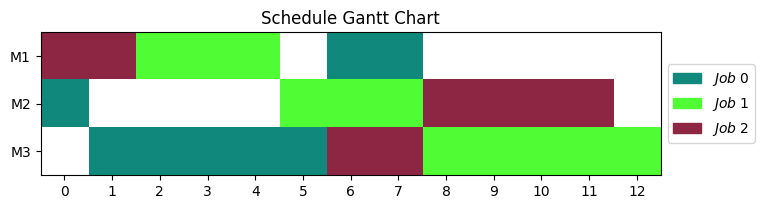

In [5]:
plot_gnatt_chart(operation_list)

The  hybrid G&T presented in (Varela et al., 2005)

In [6]:
# Input is the operation sequence, the technical sequence and the duration matrix
active_schedule = []
# Making a copy of the semi activve schedule
semi_active_schedule = copy.deepcopy(operation_list.tolist())
# Initiating the timing lists for machine and job
m_time = np.zeros(n_machines)
j_time = np.zeros(n_jobs)

T_counter = np.zeros(n_jobs, dtype=int)
next_operations = []
while len(semi_active_schedule) > 0 or len(next_operations) > 0:
    # Need to find the operation with the lowest completion time among the set of scheduable operations

    # Extract the next operations in the technological sequences    
    for i, operation in enumerate(semi_active_schedule):
        if jssp_problem[0][operation.job][T_counter[operation.job]]-1 == operation.machine:
            # if the mahcine number matches the next machine in the corresponding technical sequence, then select the operation for processing
            next_operations.append(semi_active_schedule.pop(i))

    cur_best_index_k = 0
    cur_lowest_complete_time = 0
    # Extract the start and comlpetion time for the first operation in the list
    lowest_start_time_i  = np.max([m_time[next_operations[0].machine], j_time[next_operations[0].job]])
    cur_lowest_complete_time = lowest_start_time_i + next_operations[0].duration

    # Loop to find the lowest completion time
    for i in range(1, len(next_operations)):
        # For each operation, find the lowest start time and the completion time
        lowest_start_time_i  = np.max([m_time[next_operations[i].machine], j_time[next_operations[i].job]])
        completion_i = lowest_start_time_i + next_operations[i].duration
        
        if completion_i < cur_lowest_complete_time:
            # Update the lowest completion time if it is lower than the current lowest
            cur_lowest_complete_time = completion_i
            # store the index of the operation
            cur_best_index_k = i


    found_lowest_completion_time = cur_lowest_complete_time
    machine_k = next_operations[cur_best_index_k].machine

    overall_best_index = 0
    overall_lowest_start_time = np.max([m_time[next_operations[overall_best_index].machine], j_time[next_operations[overall_best_index].job]])
    for operation_index in range(1, len(next_operations)):
        if next_operations[operation_index].machine == machine_k:
            # If the current operation is for machine_k, find the lowest starting time 
            lowest_start_time_i  = np.max([m_time[next_operations[operation_index].machine], j_time[next_operations[operation_index].job]])
            if (lowest_start_time_i < found_lowest_completion_time) & (overall_lowest_start_time > lowest_start_time_i):
                # If the starting time is lower than the the lowest completion time and the start time is lower than the previous lowest start time
                # Store index and start time for that operation
                overall_best_index = operation_index
                overall_lowest_start_time = lowest_start_time_i
            
    # Scedule the selected operation
    selected_operation = next_operations.pop(overall_best_index)
    selected_operation.start = overall_lowest_start_time
    m_time[selected_operation.machine] = selected_operation.get_completion_time()
    j_time[selected_operation.job] = selected_operation.get_completion_time()
    T_counter[selected_operation.job] += 1
    active_schedule.append(selected_operation)

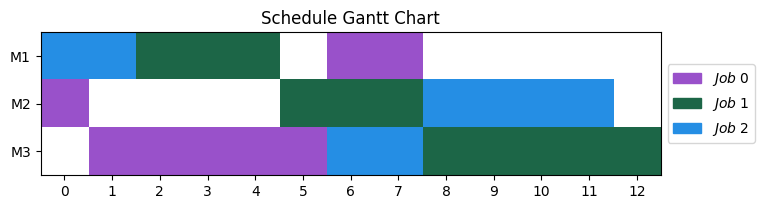

In [7]:
plot_gnatt_chart(operation_list)

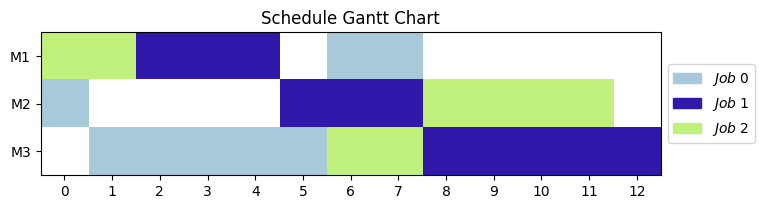

In [8]:
plot_gnatt_chart(active_schedule)

Find makespan

In [62]:
np.arange(-.5, 9, 1)

array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5])

In [70]:
[i for i in range(int(max_time))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

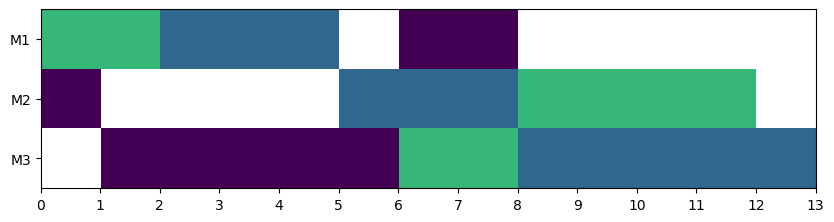

In [72]:
from matplotlib import colormaps
import matplotlib as mpl

max_time = 0
for operation in operation_list:
    if max_time < operation.get_completion_time():
        max_time = operation.get_completion_time()

cur_image = np.ones((n_machines, int(max_time), 3))

for operation in operation_list:
    cur_image[operation.machine , int(operation.start) : int(operation.get_completion_time()), :] = plt.cm.viridis(operation.job/n_jobs)[:3]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(cur_image, cmap=mpl.colormaps["viridis"])
ax.set_xticks(np.arange(-0.5, max_time, 1))
ax.set_xticklabels([int(i) for i in range(int(max_time+1))])

ax.set_yticks([i for i in range(n_machines)])
ax.set_yticklabels([f"M{i+1}" for i in range(n_machines)])

plt.show()

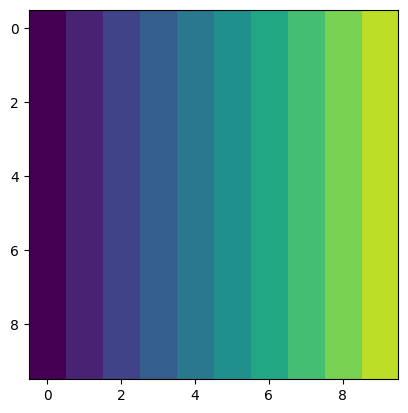

In [53]:
test_img = np.ones((10, 10, 3))*256
for i in range(10):
    test_img[:, i] = plt.cm.viridis(i/10)[:3]

plt.imshow(test_img)

(0.271305, 0.019942, 0.347269)

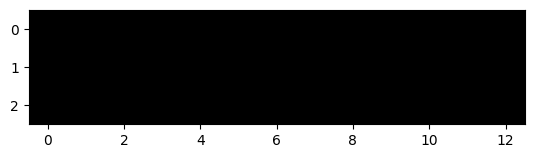

In [15]:
plt.imshow(cur_image)

In [38]:
np.max(np.linspace(0, 3, 1000))

256.0

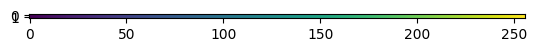

In [24]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, cmap=mpl.colormaps["viridis"])

In [43]:
operation.start

0.0

TypeError: Invalid shape (3, 13, 2) for image data

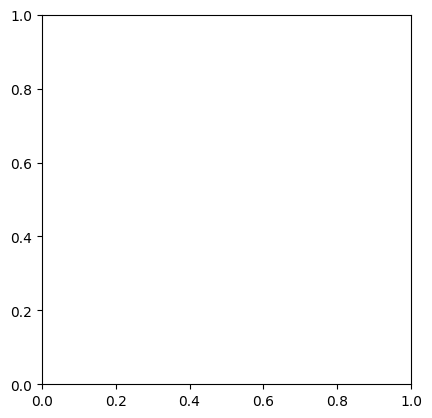

Create the permutation with m repretitions

References:

* Gen, M., Tsujimura, Y., & Kubota, E. (1994). Solving job-shop scheduling problems by genetic algorithm. Proceedings of IEEE International Conference on Systems, Man and Cybernetics, 2, 1577–1582 vol.2. https://doi.org/10.1109/ICSMC.1994.400072

* Bierwirth, C. (1995). A generalized permutation approach to job shop scheduling with genetic algorithms. Operations-Research-Spektrum, 17(2), 87–92. https://doi.org/10.1007/BF01719250

* Cheng, R., Gen, M., & Tsujimura, Y. (1996). A tutorial survey of job-shop scheduling problems using genetic algorithms—I. representation. Computers & Industrial Engineering, 30(4), 983–997. https://doi.org/10.1016/0360-8352(96)00047-2

* Varela, R., Serrano, D., & Sierra, M. (2005). New Codification Schemas for Scheduling with Genetic Algorithms. In J. Mira & J. R. Álvarez (Eds.), Artificial Intelligence and Knowledge Engineering Applications: A Bioinspired Approach (pp. 11–20). Springer. https://doi.org/10.1007/11499305_2
